In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [265]:
df = pd.read_parquet('../data/cleaned/electricity.parquet')
df = df[['index', 'MT_124']]
df = df.rename(columns={'MT_124': 'Electricity_Consumption'})
df.columns

Index(['index', 'Electricity_Consumption'], dtype='object')

Implement 24h differencing 

In [266]:
df['index'] = pd.to_datetime(df['index'])
# Ensure the 'index' column is set as the DataFrame index for time-based operations
df.set_index('index', inplace=True)

# Calculate the difference with the value from 24 hours ago
df['Consumption_Diff_24h'] = df['Electricity_Consumption'] - df['Electricity_Consumption'].shift(freq='24H')

# Reset index if needed for further processing
df.reset_index(inplace=True)
# df[85:100]
df = df.dropna().reset_index(drop=True)


In [267]:
df = df[0:15000]
df

,index,Electricity_Consumption,Consumption_Diff_24h
0,2011-01-02 00:15:00,411.483254,339.712919
1,2011-01-02 00:30:00,406.698565,334.928230
2,2011-01-02 00:45:00,325.358852,263.157895
3,2011-01-02 01:00:00,344.497608,272.727273
4,2011-01-02 01:15:00,411.483254,344.497608
...,...,...,...
14995,2011-06-07 05:00:00,138.755981,23.923445
14996,2011-06-07 05:15:00,133.971292,23.923445
14997,2011-06-07 05:30:00,138.755981,14.354067
14998,2011-06-07 05:45:00,129.186603,38.277512


## Stationarity Analysis

In [268]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

def stationarity_analysis(df, dataset_name, column_name = None):
    """
    column_name: specify the column to analyze, default is 'Close'
    Perform ADF and KPSS tests for stationarity analysis
    """
    data = df['Close'] if column_name is None else df[column_name]
    
    data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
    print(f"\n{'='*50}")
    print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # ADF Test
    print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
    adf_result = adfuller(data, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.6f}")
    
    if adf_result[1] <= 0.05:
        print("ADF Result: STATIONARY (Reject null hypothesis)")
    else:
        print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
    # KPSS Test
    print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
    kpss_result = kpss(data, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.6f}")
    
    if kpss_result[1] <= 0.05:
        print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
    else:
        print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
    # Combined interpretation
    print("\n--- COMBINED INTERPRETATION ---")
    adf_stationary = adf_result[1] <= 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("CONCLUSION: Series is STATIONARY")
    elif not adf_stationary and not kpss_stationary:
        print("CONCLUSION: Series is NON-STATIONARY")
    else:
        print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")

# stationarity_analysis(df=df, dataset_name="Elec_Raws", column_name='Electricity_Consumption')
# stationarity_analysis(df=df, dataset_name="Elec_Diff_24h", column_name='Consumption_Diff_24h')

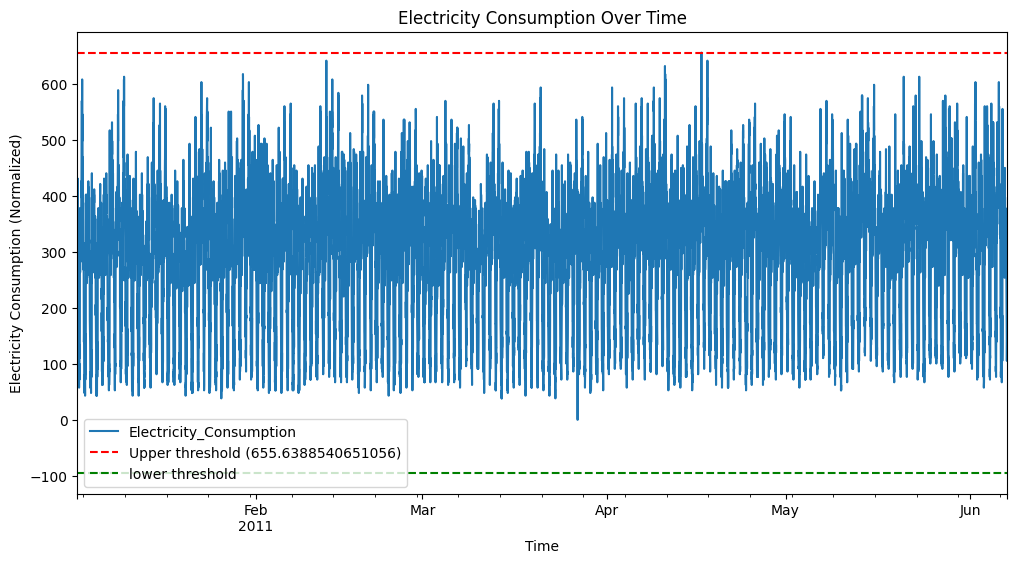

In [269]:
df.plot(x='index', y='Electricity_Consumption', title='Electricity Consumption Over Time', figsize=(12, 6))
# draw two horisontal lines at y=0.2 and y=0.8
STD = 3
df['Electricity_Consumption'].mean(), df['Electricity_Consumption'].std()
UTH = df['Electricity_Consumption'].mean() + STD*df['Electricity_Consumption'].std()
LTH = df['Electricity_Consumption'].mean() - STD*df['Electricity_Consumption'].std()
plt.axhline(y=df['Electricity_Consumption'].mean() + STD*df['Electricity_Consumption'].std(), color='r', linestyle='--', label=f'Upper threshold ({UTH})')
plt.axhline(y=df['Electricity_Consumption'].mean() - STD*df['Electricity_Consumption'].std(), color='g', linestyle='--', label='lower threshold')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (Normalized)')
plt.legend()
plt.show()

In [270]:
# df['Electricity_Consumption'].mean(), df['Electricity_Consumption'].std()

# # count the number of outliers in the Electricity_Consumption column
# outliers = df[(df['Electricity_Consumption'] > df['Electricity_Consumption'].mean() + 3*df['Electricity_Consumption'].std()) | (df['Electricity_Consumption'] < df['Electricity_Consumption'].mean() - 3*df['Electricity_Consumption'].std())]
# print(len(outliers))
# outliers

# mean_lr = df['Electricity_Consumption'].mean()
# std_lr = df['Electricity_Consumption'].std()
# CLAMP_STD = 3

# upper = mean_lr + CLAMP_STD * std_lr
# lower = mean_lr - CLAMP_STD * std_lr

# df['Electricity_Consumption'] = np.where(df['Electricity_Consumption'] > upper, upper,
#                         np.where(df['Electricity_Consumption'] < lower, lower, df['Electricity_Consumption']))


# # count the number of outliers in the Electricity_Consumption column
# outliers = df[(df['Electricity_Consumption'] > UTH) | (df['Electricity_Consumption'] < LTH)]
# len(outliers)
# # outliers


In [271]:
# df.plot(x='index', y='Electricity_Consumption', title='Electricity Consumption Over Time', figsize=(12, 6))
# # draw two horisontal lines at y=0.2 and y=0.8
# STD = 3
# df['Electricity_Consumption'].mean(), df['Electricity_Consumption'].std()
# plt.axhline(y=df['Electricity_Consumption'].mean() + STD*df['Electricity_Consumption'].std(), color='r', linestyle='--', label=f'Upper threshold ({UTH})')
# plt.axhline(y=df['Electricity_Consumption'].mean() - STD*df['Electricity_Consumption'].std(), color='g', linestyle='--', label=f'lower threshold ({LTH})')
# plt.xlabel('Time')
# plt.ylabel('Electricity Consumption (Normalized)')
# plt.legend()
# plt.show()

In [272]:
features = ['Consumption_Diff_24h']
X = df[features].values[:-1]  # All but last
y = df['Consumption_Diff_24h'].values[1:]  # All but first (shifted by +1)

In [273]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit  # For guidance, but implementing custom rolling for financial data
torch.manual_seed(42)

# Step 1: Define Elman RNN Model
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(ElmanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Step 2: Custom Dataset for Sequences
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, seq_len=10):
        self.data = data
        self.targets = targets
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.FloatTensor(x), torch.FloatTensor([y])

class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        Jordan RNN Model. The num_layers parameter is kept for API consistency
        but this implementation uses a single hidden layer.
        """
        super(JordanRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # The RNN cell takes the input and the combined hidden+previous_output state
        self.rnn_cell = nn.RNNCell(input_size + output_size, hidden_size)
        
        # Fully connected layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        hidden = torch.zeros(batch_size, self.hidden_size).to(x.device)
        prev_output = torch.zeros(batch_size, self.fc.out_features).to(x.device)

        for t in range(seq_len):
            # Use previous timestep's output
            combined_input = torch.cat((x[:, t, :], prev_output), dim=1)
            hidden = self.rnn_cell(combined_input, hidden)
            
            # Compute current output
            current_output = self.fc(hidden)
            
            # Update prev_output for NEXT iteration
            prev_output = current_output
            
        return current_output
    
class MultiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        Multi-Recurrent Neural Network (MultiRNN) - Combination of Elman and Jordan RNNs
        
        This network feeds back both:
        1. Previous hidden state (like Elman RNN)
        2. Previous output (like Jordan RNN)
        
        Args:
            input_size: Number of input features
            hidden_size: Number of hidden units
            output_size: Number of output features
            num_layers: Number of layers (kept for API consistency, uses single layer)
        """
        super(MultiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # The RNN cell takes input + previous_hidden + previous_output
        # Input concatenation: [current_input, prev_hidden, prev_output]
        self.rnn_cell = nn.RNNCell(input_size + hidden_size + output_size, hidden_size)
        
        # Fully connected layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass through the MultiRNN
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
            
        Returns:
            Output tensor of shape (batch_size, output_size)
        """
        # Get batch size and sequence length
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Initialize hidden state and output for the first time step
        hidden = torch.zeros(batch_size, self.hidden_size).to(x.device)
        prev_output = torch.zeros(batch_size, self.output_size).to(x.device)

        # Manually loop through each time step in the sequence
        for t in range(seq_len):
            # Concatenate current input, previous hidden state, and previous output
            # This is the key difference: we use BOTH prev_hidden and prev_output
            combined_input = torch.cat((x[:, t, :], hidden, prev_output), dim=1)
            
            # Update the hidden state using the combined input
            hidden = self.rnn_cell(combined_input, hidden)
            
            # Calculate the current output based on the new hidden state
            current_output = self.fc(hidden)
            
            # Update prev_output for the next time step
            prev_output = current_output
            
        # Return the final output (output from the last time step)
        return current_output


## Model parameters and train validation test splitting

In [274]:

# Parameters
seq_len = 15
batch_size = 64
num_layers = 1
epochs = 100
n_folds = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 1
output_size = 1

# --- New: one overarching train/holdout split at the beginning (holdout is the last chunk of the series)
holdout_ratio = 0.3  # fraction kept for final test at the end
n_total = len(X)
holdout_size = int(holdout_ratio * n_total)

# Training and validation portion
X_trainval = X[:-holdout_size]
y_trainval = y[:-holdout_size]

# Held out portion
X_holdout = X[-holdout_size:]
y_holdout = y[-holdout_size:]

# --- Clamp outliers based ONLY on the training data statistics to prevent data leakage ---
CLAMP_STD = 3
# Calculate mean and standard deviation from the training/validation set only
mean_X = X_trainval.mean()
std_X = X_trainval.std()

# Define the upper and lower bounds
lower_bound = mean_X - CLAMP_STD * std_X
upper_bound = mean_X + CLAMP_STD * std_X

# Clamp both the training/validation set and the holdout set using the training statistics
X_trainval = np.clip(X_trainval, lower_bound, upper_bound)

# --- Growing-window CV on the training+validation portion
results = {'fold': [], 'rmse': [], 'mae': []}

n_trainval = len(X_trainval)
# initial training window inside trainval (choose a sensible starting window)
initial_train_ratio = 0.5
initial_train_window = max(int(initial_train_ratio * n_trainval), seq_len + 1)
remaining = n_trainval - initial_train_window
if remaining < n_folds:  # ensure at least one sample per test fold
    raise ValueError("Not enough data in training portion to create the requested number of folds. Reduce n_folds or holdout_ratio.")

fold_test_size = max(1, remaining // n_folds)

### Gridsearch CV

In [275]:
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error


def gridsearchCV_RNNs(model_to_use='Elman'):

    # Step 1: Define the grid of hyperparameters to search over
    param_grid = {
        'hidden_size': range(32, 97, 32),
        'learning_rate': [0.00001, 0.0001, 0.0005, 0.001],
        'seq_len': range(10, 31, 15),
        'weight_decay': [1e-5, 1e-4, 1e-3],  # Add this line
        'patience': [10]  # Add this line
    }

    # --- Store results for each parameter combination ---
    grid_search_results = []
    keys, values = zip(*param_grid.items())

    # Step 2: Outer loop for Grid Search
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        
        # Unpack current hyperparameters
        hidden_size = params['hidden_size']
        learning_rate = params['learning_rate']
        seq_len = params['seq_len']
        weight_decay = params['weight_decay']
        patience = params['patience']
        
        # You can unpack others like batch_size here if you add them to the grid
        
        print(f"\n{'='*60}")
        print(f"TESTING HYPERPARAMETERS: {params}")
        print(f"{'='*60}")
        
        # Store results for the folds of this specific parameter set
        current_param_fold_results = {'rmse': [], 'mae': []}

        # Step 3: Inner loop for Growing-Window Cross-Validation
        for fold in range(n_folds):
            train_start = 0
            train_end = initial_train_window + fold * fold_test_size
            test_start = train_end
            test_end = min(test_start + fold_test_size, n_trainval)

            # Ensure there's enough data
            if train_end - train_start < seq_len + 1 or test_end - test_start < seq_len + 1:
                print(f"Skipping fold {fold}: Insufficient data for seq_len={seq_len}")
                continue

            # Extract fold data
            X_tr, y_tr = X_trainval[train_start:train_end], y_trainval[train_start:train_end]
            X_te, y_te = X_trainval[test_start:test_end], y_trainval[test_start:test_end]

            # Split training data into train/validation for early stopping
            val_split = 0.2
            train_split_idx = int(len(X_tr) * (1 - val_split))
            
            X_train_fold = X_tr[:train_split_idx]
            y_train_fold = y_tr[:train_split_idx]
            X_val_fold = X_tr[train_split_idx:]
            y_val_fold = y_tr[train_split_idx:]

            # Scale data
            scaler_X = StandardScaler().fit(X_train_fold)  # Fit only on training portion
            X_train_scaled = scaler_X.transform(X_train_fold)
            X_val_scaled = scaler_X.transform(X_val_fold)
            X_te_scaled = scaler_X.transform(X_te)
            
            scaler_y = StandardScaler().fit(y_train_fold.reshape(-1, 1))
            y_train_scaled = scaler_y.transform(y_train_fold.reshape(-1, 1)).flatten()
            y_val_scaled = scaler_y.transform(y_val_fold.reshape(-1, 1)).flatten()
            y_te_scaled = scaler_y.transform(y_te.reshape(-1, 1)).flatten()

            # Create datasets & loaders
            train_dataset = TimeSeriesDataset(X_train_scaled, y_train_scaled, seq_len)
            val_dataset = TimeSeriesDataset(X_val_scaled, y_val_scaled, seq_len)
            test_dataset = TimeSeriesDataset(X_te_scaled, y_te_scaled, seq_len)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Initialize model
            if model_to_use == 'Jordan':
                model = JordanRNN(input_size, hidden_size, output_size, num_layers).to(device)
            elif model_to_use == 'Elman':
                model = ElmanRNN(input_size, hidden_size, output_size, num_layers).to(device)
            elif model_to_use == 'Multi':
                model = MultiRNN(input_size, hidden_size, output_size, num_layers).to(device)
            
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Training with Early Stopping
            best_val_loss = float('inf')
            patience_counter = 0
            best_model_state = None
            
            for epoch in range(epochs):
                # Training phase
                model.train()
                for batch_x, batch_y in train_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_x)
                    loss = criterion(outputs.squeeze(), batch_y)
                    loss.backward()
                    optimizer.step()

                # Validation phase (after each epoch)
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_x, batch_y in val_loader:
                        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                        outputs = model(batch_x)
                        val_loss += criterion(outputs.squeeze(), batch_y).item()
                
                val_loss /= len(val_loader)

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = model.state_dict().copy()  # Save best model state
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} for fold {fold}")
                    break
            
            # Load best model for evaluation
            if best_model_state is not None:
                model.load_state_dict(best_model_state)

            # Evaluation on the actual test set (unseen during training/validation)
            model.eval()
            predictions = []
            with torch.no_grad():
                for batch_x, _ in test_loader:  # Use test_loader, not val_loader
                    batch_x = batch_x.to(device)
                    outputs = model(batch_x)
                    predictions.extend(outputs.squeeze().cpu().numpy())

            predictions = np.array(predictions)
            true_y = y_te_scaled[seq_len:]
            predictions = predictions[:len(true_y)]

            rmse = np.sqrt(mean_squared_error(true_y, predictions))
            mae = mean_absolute_error(true_y, predictions)

            current_param_fold_results['rmse'].append(rmse)
            current_param_fold_results['mae'].append(mae)

        # After all folds for the current param set are done, calculate the average score
        if current_param_fold_results['rmse']: # Check if any folds ran
            mean_rmse = np.mean(current_param_fold_results['rmse'])
            mean_mae = np.mean(current_param_fold_results['mae'])
            
            # print(f"\n--- Avg CV Score for {params}: RMSE = {mean_rmse:.4f}, MAE = {mean_mae:.4f} ---")
            
            grid_search_results.append({
                'params': params,
                'mean_rmse': mean_rmse,
                'mean_mae': mean_mae
            })

    # Step 4: Find and print the best hyperparameter combination
    if grid_search_results:
        best_params_result = min(grid_search_results, key=lambda x: x['mean_rmse'])
        print(f"\n{'='*60}")
        print("GRID SEARCH COMPLETE for model:", model_to_use)
        print(f"Best Hyperparameters found: {best_params_result['params']}")
        print(f"Best Mean CV RMSE: {best_params_result['mean_rmse']:.4f}")
        print(f"{'='*60}")
        return best_params_result
    else:
        print("\nGrid search did not complete. Check data size and parameters.")

# Final Testing

### Preparing final testing data

In [276]:


# Final: retrain on entire trainval and evaluate once on the held-out end-of-series test set
# Fit scalers on whole trainval
scaler_X_full = StandardScaler().fit(X_trainval)
X_trainval_scaled = scaler_X_full.transform(X_trainval)
X_holdout_scaled = scaler_X_full.transform(X_holdout)

scaler_y_full = StandardScaler().fit(y_trainval.reshape(-1, 1))
y_trainval_scaled = scaler_y_full.transform(y_trainval.reshape(-1, 1)).flatten()
y_holdout_scaled = scaler_y_full.transform(y_holdout.reshape(-1, 1)).flatten()


# Final Elman

In [277]:
# Store results separately
elman_params = {'hidden_size': 32, 'learning_rate': 0.0005, 'seq_len': 10, 'weight_decay': 0.001, 'patience': 10}
jordan_params = {'hidden_size': 64, 'learning_rate': 0.0001, 'seq_len': 10, 'weight_decay': 1e-05, 'patience': 10} 
multi_params = {'hidden_size': 32, 'learning_rate': 0.0005, 'seq_len': 10, 'weight_decay': 0.001, 'patience': 10}

In [278]:
# Create separate final models for each architecture
print("Training Elman RNN...")
final_model_elman = ElmanRNN(input_size, elman_params['hidden_size'], output_size, num_layers).to(device)
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled, seq_len=elman_params['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled, seq_len=elman_params['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# Train Elman
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model_elman.parameters(), lr=elman_params['learning_rate'], weight_decay=elman_params['weight_decay'])
final_model_elman.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model_elman(batch_x)
        loss = criterion(outputs.squeeze(-1), batch_y.squeeze(-1))
        loss.backward()
        optimizer.step()

# Get Elman predictions
final_model_elman.eval()
elman_predictions = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model_elman(batch_x)
        elman_predictions.extend(np.atleast_1d(outputs.squeeze().cpu().numpy()))

elman_predictions = np.array(elman_predictions)
elman_y_pred_inv = scaler_y_full.inverse_transform(elman_predictions.reshape(-1, 1)).flatten()

print("Training Jordan RNN...")
final_model_jordan = JordanRNN(input_size, jordan_params['hidden_size'], output_size, num_layers).to(device)
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled, seq_len=jordan_params['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled, seq_len=jordan_params['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# Train Jordan
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model_jordan.parameters(), lr=jordan_params['learning_rate'], weight_decay=jordan_params['weight_decay'])
final_model_jordan.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model_jordan(batch_x)
        loss = criterion(outputs.squeeze(-1), batch_y.squeeze(-1))
        loss.backward()
        optimizer.step()

# Get Jordan predictions
final_model_jordan.eval()
jordan_predictions = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model_jordan(batch_x)
        jordan_predictions.extend(np.atleast_1d(outputs.squeeze().cpu().numpy()))

jordan_predictions = np.array(jordan_predictions)
jordan_y_pred_inv = scaler_y_full.inverse_transform(jordan_predictions.reshape(-1, 1)).flatten()

print("Training Multi RNN...")
final_model_multi = MultiRNN(input_size, multi_params['hidden_size'], output_size, num_layers).to(device)
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled, seq_len=multi_params['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled, seq_len=multi_params['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# Train Multi
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model_multi.parameters(), lr=multi_params['learning_rate'], weight_decay=multi_params['weight_decay'])
final_model_multi.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model_multi(batch_x)
        loss = criterion(outputs.squeeze(-1), batch_y.squeeze(-1))
        loss.backward()
        optimizer.step()

# Get Multi predictions
final_model_multi.eval()
multi_predictions = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model_multi(batch_x)
        multi_predictions.extend(np.atleast_1d(outputs.squeeze().cpu().numpy()))

multi_predictions = np.array(multi_predictions)
multi_y_pred_inv = scaler_y_full.inverse_transform(multi_predictions.reshape(-1, 1)).flatten()

Training Elman RNN...
Training Jordan RNN...
Training Multi RNN...



Model Comparison:
Elman RNN - RMSE: 58.4710, MAE: 40.0989
Jordan RNN - RMSE: 59.1565, MAE: 40.5666
Multi RNN - RMSE: 58.5584, MAE: 39.9769

Model Comparison (Reconstructed Closing Prices):
Elman RNN - RMSE: 58.470965, MAE: 40.0989, MAPE: 10793980.00%
Jordan RNN - RMSE: 322.612614, MAE: 292.0271, MAPE: 13505192.00%
Multi RNN - RMSE: 58.558414, MAE: 39.9769, MAPE: 11046144.00%


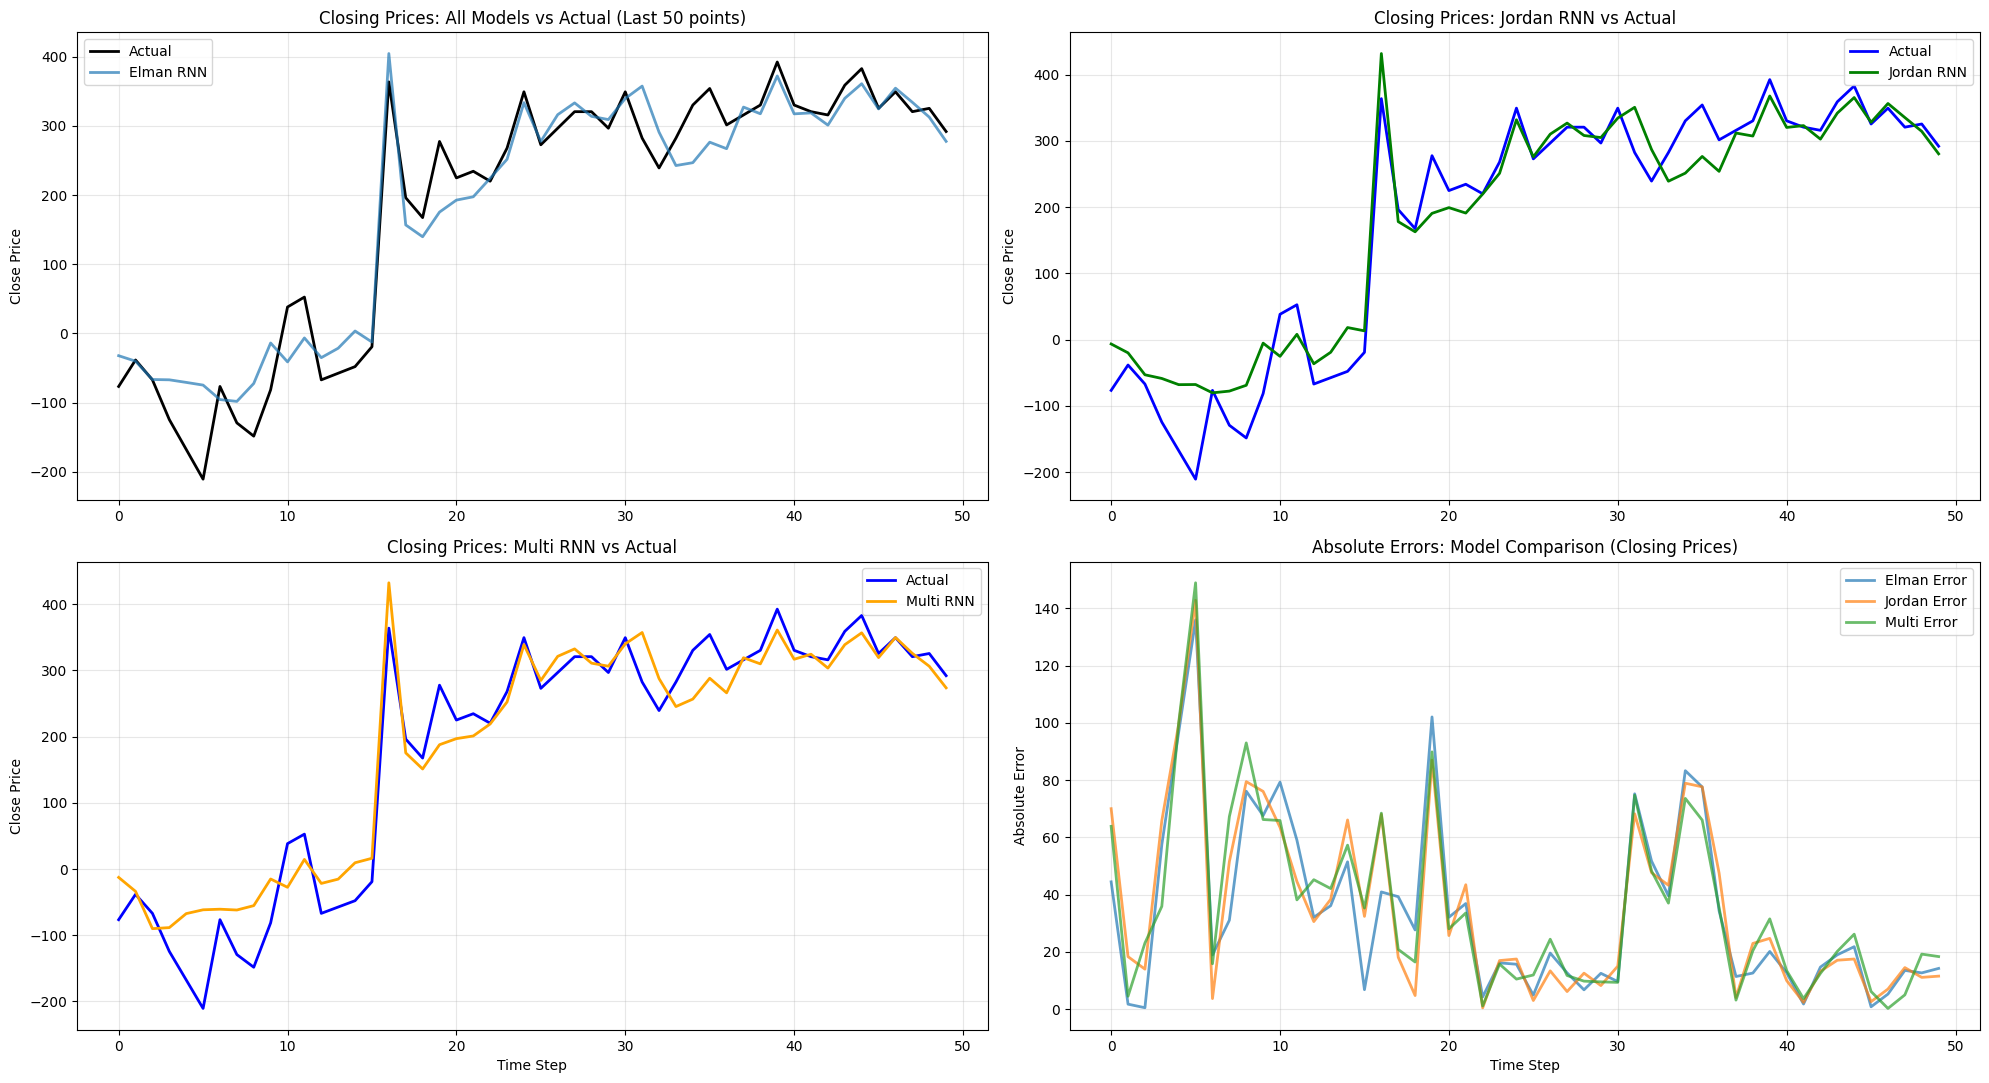

In [283]:
# Get true values for comparison
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        true_vals.extend(batch_y.numpy().flatten())

true_y = np.array(true_vals)
y_true_inv = scaler_y_full.inverse_transform(true_y.reshape(-1, 1)).flatten()

# Calculate metrics for all models
models_results = {
    'Elman': {
        'predictions': elman_y_pred_inv,
        'rmse': np.sqrt(mean_squared_error(y_true_inv, elman_y_pred_inv)),
        'mae': mean_absolute_error(y_true_inv, elman_y_pred_inv)
    },
    'Jordan': {
        'predictions': jordan_y_pred_inv,
        'rmse': np.sqrt(mean_squared_error(y_true_inv, jordan_y_pred_inv)),
        'mae': mean_absolute_error(y_true_inv, jordan_y_pred_inv)
    },
    'Multi': {
        'predictions': multi_y_pred_inv,
        'rmse': np.sqrt(mean_squared_error(y_true_inv, multi_y_pred_inv)),
        'mae': mean_absolute_error(y_true_inv, multi_y_pred_inv)
    }
}

# Print comparison
print("\nModel Comparison:")
print("=" * 50)
for model_name, results in models_results.items():
    print(f"{model_name} RNN - RMSE: {results['rmse']:.4f}, MAE: {results['mae']:.4f}")

# Get the actual usage corresponding to the holdout period
holdout_start_idx = len(df) - len(y_holdout) - elman_params['seq_len']

def reconstruct_electricity_consumption(diff_predictions, diff_actual, base_consumption):
    """
    Reconstruct actual electricity consumption from 24-hour differences
    
    Args:
        diff_predictions: predicted 24-hour differences (scaled back to original range)
        diff_actual: actual 24-hour differences (scaled back to original range)  
        base_consumption: the electricity consumption values from 24 hours ago
    
    Returns:
        predicted_consumption, actual_consumption: reconstructed consumption values
    """
    predicted_consumption = np.zeros_like(diff_predictions)
    actual_consumption = np.zeros_like(diff_actual)
    
    for i in range(len(diff_predictions)):
        # For 24-hour differencing: consumption[t] = consumption[t-24] + difference[t]
        if i < len(base_consumption):
            # Use the corresponding base consumption from 24 hours ago
            base_value = base_consumption[i]
        else:
            # If we run out of base values, use the pattern or last available
            # This assumes your base_consumption array is properly sized
            base_value = base_consumption[-1]
            
        predicted_consumption[i] = base_value + diff_predictions[i]
        actual_consumption[i] = base_value + diff_actual[i]
    
    return predicted_consumption, actual_consumption

# Usage in your code:
# Get the base consumption values (from 24 hours before the holdout period)
holdout_start_idx = len(df) - len(y_holdout) - elman_params['seq_len']
base_consumption_start = holdout_start_idx - 24  # Go back 24 hours

# Extract base consumption values (the values from 24 hours before each prediction point)
base_consumption = df['Electricity_Consumption'].iloc[base_consumption_start:base_consumption_start + len(y_true_inv)].values

# Reconstruct consumption for all models
elman_consumption, actual_consumption = reconstruct_electricity_consumption(
    elman_y_pred_inv, y_true_inv, base_consumption
)

jordan_consumption, _ = reconstruct_electricity_consumption(
    jordan_y_pred_inv, y_true_inv, base_consumption
)

multi_consumption, _ = reconstruct_electricity_consumption(
    multi_y_pred_inv, y_true_inv, base_consumption
)

# Calculate price-based metrics
price_results = {
    'Elman': {
        'prices': elman_consumption,
        'rmse': np.sqrt(mean_squared_error(actual_consumption, elman_consumption)),
        'mae': mean_absolute_error(actual_consumption, elman_consumption),
        'mape': np.mean(np.abs((actual_consumption - elman_consumption) / actual_consumption)) * 100
    },
    'Jordan': {
        'prices': jordan_y_pred_inv,
        'rmse': np.sqrt(mean_squared_error(actual_consumption, jordan_y_pred_inv)),
        'mae': mean_absolute_error(actual_consumption, jordan_y_pred_inv),
        'mape': np.mean(np.abs((actual_consumption - jordan_y_pred_inv) / actual_consumption)) * 100
    },
    'Multi': {
        'prices': multi_consumption,
        'rmse': np.sqrt(mean_squared_error(actual_consumption, multi_consumption)),
        'mae': mean_absolute_error(actual_consumption, multi_consumption),
        'mape': np.mean(np.abs((actual_consumption - multi_consumption) / actual_consumption)) * 100
    }
}

print("\nModel Comparison (Reconstructed Closing Prices):")
print("=" * 60)
for model_name, results in price_results.items():
    print(f"{model_name} RNN - RMSE: {results['rmse']:.6f}, MAE: {results['mae']:.4f}, MAPE: {results['mape']:.2f}%")

# Extended plotting with both log returns and reconstructed prices
plt.figure(figsize=(20, 16))

plot_lookback = 50

# RECONSTRUCTED CLOSING PRICES PLOTS
# Plot 3: All models vs actual (Closing Prices)
plt.subplot(3, 2, 3)
plt.plot(actual_consumption[-plot_lookback:], label='Actual', linewidth=2, color='black')
plt.plot(elman_consumption[-plot_lookback:], label='Elman RNN', linewidth=2, alpha=0.7)
# plt.plot(jordan_y_pred_inv[-plot_lookback:], label='Jordan RNN', linewidth=2, alpha=0.7)
# plt.plot(multi_consumption[-plot_lookback:], label='Multi RNN', linewidth=2, alpha=0.7)
plt.title(f'Closing Prices: All Models vs Actual (Last {plot_lookback} points)')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Jordan vs Actual (Closing Prices)
plt.subplot(3, 2, 4)
plt.plot(actual_consumption[-plot_lookback:], label='Actual', linewidth=2, color='blue')
plt.plot(jordan_consumption[-plot_lookback:], label='Jordan RNN', linewidth=2, color='green')
plt.title('Closing Prices: Jordan RNN vs Actual')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Multi vs Actual (Closing Prices)
plt.subplot(3, 2, 5)
plt.plot(actual_consumption[-plot_lookback:], label='Actual', linewidth=2, color='blue')
plt.plot(multi_consumption[-plot_lookback:], label='Multi RNN', linewidth=2, color='orange')
plt.title('Closing Prices: Multi RNN vs Actual')
plt.ylabel('Close Price')
plt.xlabel('Time Step')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Error comparison across models (Closing Prices)
plt.subplot(3, 2, 6)
errors_elman = np.abs(actual_consumption - elman_consumption)
errors_jordan = np.abs(actual_consumption - jordan_consumption)
errors_multi = np.abs(actual_consumption - multi_consumption)

plt.plot(errors_elman[-plot_lookback:], label='Elman Error', linewidth=2, alpha=0.7)
plt.plot(errors_jordan[-plot_lookback:], label='Jordan Error', linewidth=2, alpha=0.7)
plt.plot(errors_multi[-plot_lookback:], label='Multi Error', linewidth=2, alpha=0.7)
plt.title('Absolute Errors: Model Comparison (Closing Prices)')
plt.ylabel('Absolute Error')
plt.xlabel('Time Step')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../report/plots/rnn_model_comparison_elec.pdf')
plt.show()

# Old stuff

In [280]:
# gridsearchCV_RNNs(model_to_use='Elman')

In [281]:
# gridsearchCV_RNNs(model_to_use='Jordan')

In [282]:
# gridsearchCV_RNNs(model_to_use='Multi')